# 0) Estimation HEF par composant

# 0.1) Precision sur les architectures simplifiées

## 0.1) For transformer data import

In [29]:
import pandas as pd 
import pickle
import importlib
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import seaborn as sns
from collections import Counter 
from functions import *
data=pd.read_csv('dataForTransformerHEF.csv', skiprows=None,usecols=None) 

In [30]:
data.columns

Index(['Unnamed: 0', 'operation', 'gpu_util', 'mem_used_MB',
       'elapsed_time_sec', 'FLOPs', 'energy_consumed_kWh',
       'total_gpu_energy_kWh', 'total_cpu_energy_kWh', 'total_ram_energy_kWh',
       'seq_len', 'memory_access', 'd_model', 'source', 'peak',
       'flops_per_second', 'HEF', 'component'],
      dtype='object')

In [3]:
pd.crosstab(data['operation'],data['component'])

component,Attention Output,Attention Scores,Projections,attention_softmax
operation,,,,
Attention Output,600,0,0,0
Attention Scores,0,600,0,0
Final Projection,0,0,600,0
QKV Projections,0,0,600,0
attention_softmax,0,0,0,600


In [4]:
pd.crosstab(data['source'],data['d_model'])

d_model,128,192,256,320,384,448,512,576,640,704,768,832,896,960,1024,1088,1152,1216,1280,1344
source,,,,,,,,,,,,,,,,,,,,
NVIDIA A100 80GB PCIe,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
NVIDIA GeForce RTX 2080 Ti,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50


## HEF for Transformers components

/home/mmayaki/ml/hef/ECAI2025/functions.py:58: RuntimeWarning: overflow encountered in power
  return L * (1 - np.exp(-k * x**d))
/home/mmayaki/ml/hef/ECAI2025/functions.py:58: RuntimeWarning: overflow encountered in exp
  return L * (1 - np.exp(-k * x**d))
/home/mmayaki/ml/hef/ECAI2025/functions.py:58: RuntimeWarning: overflow encountered in multiply
  return L * (1 - np.exp(-k * x**d))


Source=NVIDIA A100 80GB PCIe, coef Attention Output, :[66.82780307  8.65309218  0.79642181]
Source=NVIDIA GeForce RTX 2080 Ti, coef Attention Output, :[78.55339849 21.77296734  0.55853927]
Source=NVIDIA A100 80GB PCIe, coef Attention Scores, :[56.46768847  8.09405701  0.79619152]
Source=NVIDIA GeForce RTX 2080 Ti, coef Attention Scores, :[71.42163036 14.24767707  0.5206079 ]
Source=NVIDIA A100 80GB PCIe, coef Projections, :[68.60693386  7.75163818  0.74128378]
Source=NVIDIA GeForce RTX 2080 Ti, coef Projections, :[81.3799271  14.89435346  0.48080831]


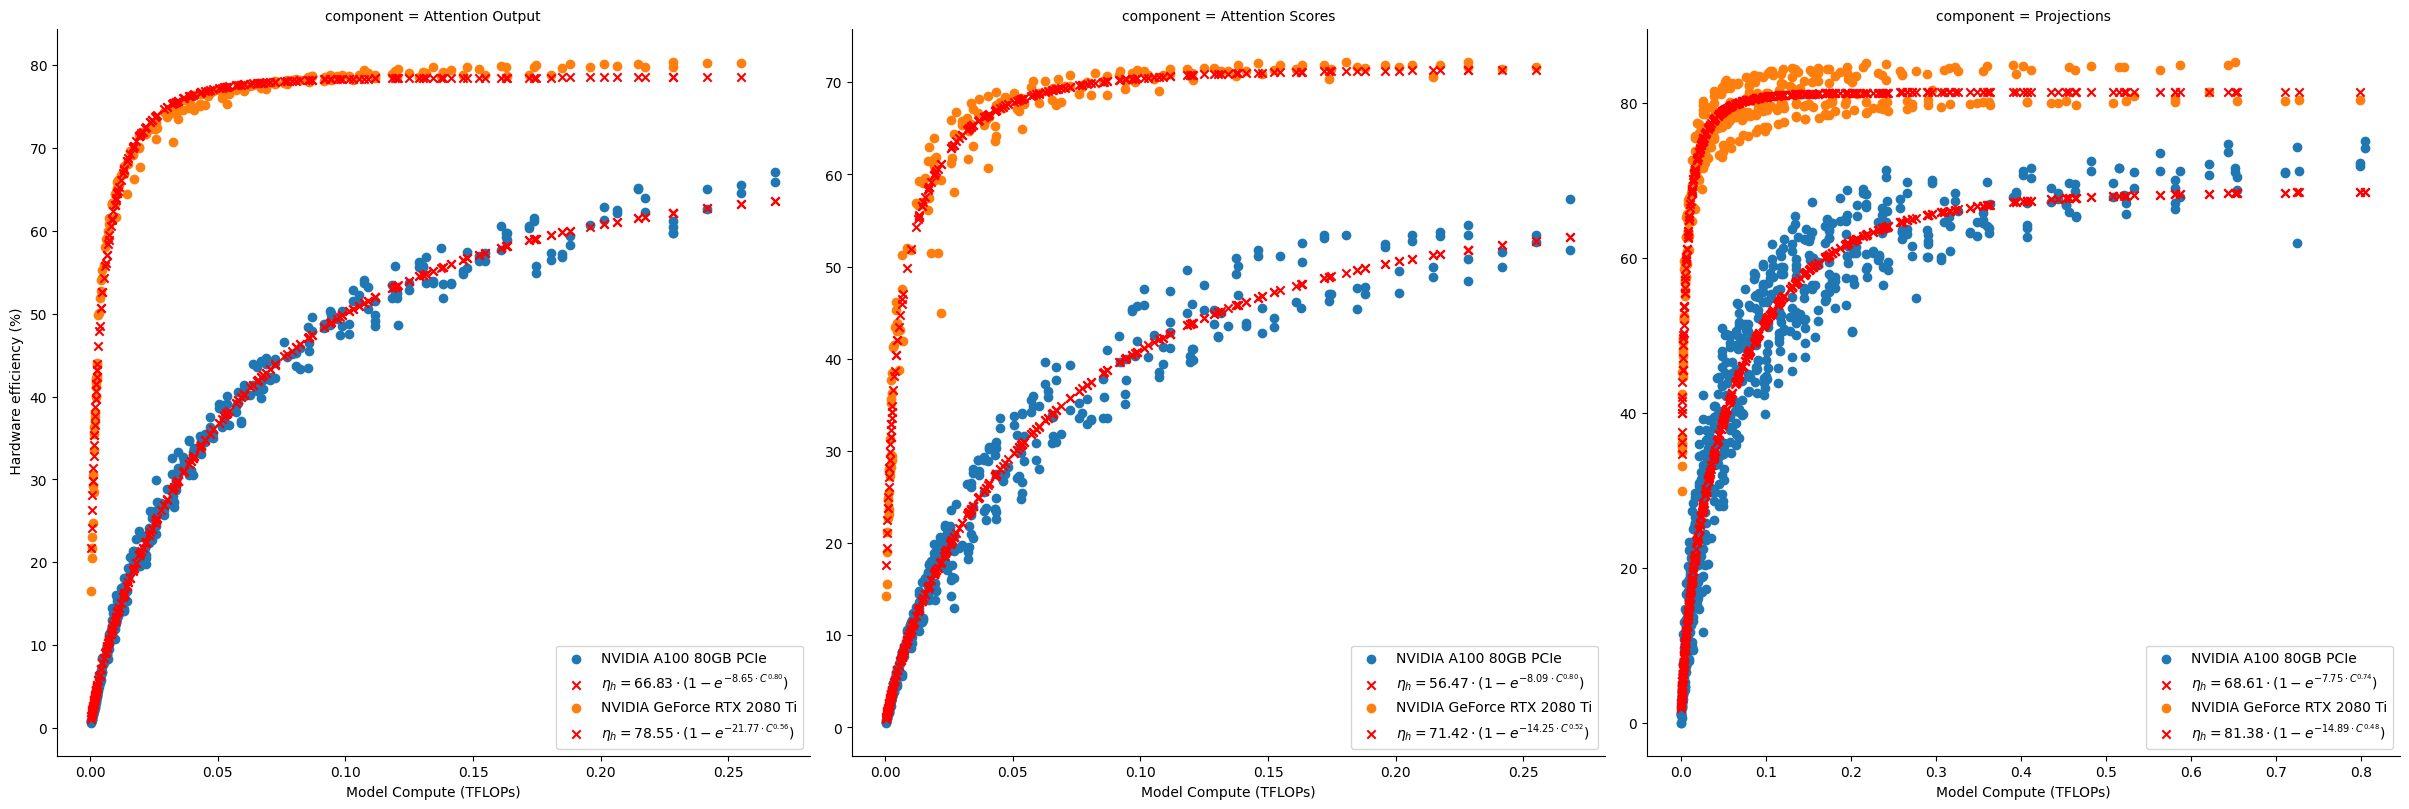

In [33]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
def general_exponential(x, a, b, c,d):
    return a * (1 - np.exp(-b * x ** c))+d**2

df=data[data['operation']!='attention_softmax'].copy()

a100=df[df['source']=='NVIDIA A100 80GB PCIe'].copy()
a100 = exclude_outliers_by_trend(
    a100,
    group_col='component',
    value_col='HEF',
    num_std=2
)

grid=df[df['source']!='NVIDIA A100 80GB PCIe'].copy()
grid = exclude_outliers_by_trend(
    grid,
    group_col='component',
    value_col='HEF',
    window_size=5,
    num_std=2
)
df=pd.concat([a100,grid],axis=0)


df["FLOPs"]=df["FLOPs"]/1e12

g = sns.FacetGrid(df, col="component",  hue="source",col_wrap=3, height=8, sharex=False, sharey=False)

g.map_dataframe(plot_exponential_decay_fit, x_col="FLOPs", y_col="HEF", data=df)
for ax in g.axes.flat:
    ax.legend(loc="best")  # Customize legend position
# If you need to adjust spacing or add a main title:
#g.fig.suptitle("Hardware Efficiency vs FLOPs by Model", y=1.05)
g.set_axis_labels("Model Compute (TFLOPs)", " Hardware efficiency (%)")
#plt.savefig("images/HEF_component.eps")
#plt.savefig("HEF_component.png")

plt.show()

In [37]:
a100.columns

Index(['Unnamed: 0', 'operation', 'gpu_util', 'mem_used_MB',
       'elapsed_time_sec', 'FLOPs', 'energy_consumed_kWh',
       'total_gpu_energy_kWh', 'total_cpu_energy_kWh', 'total_ram_energy_kWh',
       'seq_len', 'memory_access', 'd_model', 'source', 'peak',
       'flops_per_second', 'HEF', 'component', 'rolling_mean', 'difference'],
      dtype='object')

In [43]:
Counter(a100['seq_len'])

Counter({640: 121,
         512: 113,
         896: 110,
         128: 101,
         256: 88,
         384: 87,
         768: 86,
         1152: 85,
         1280: 82,
         1024: 78})

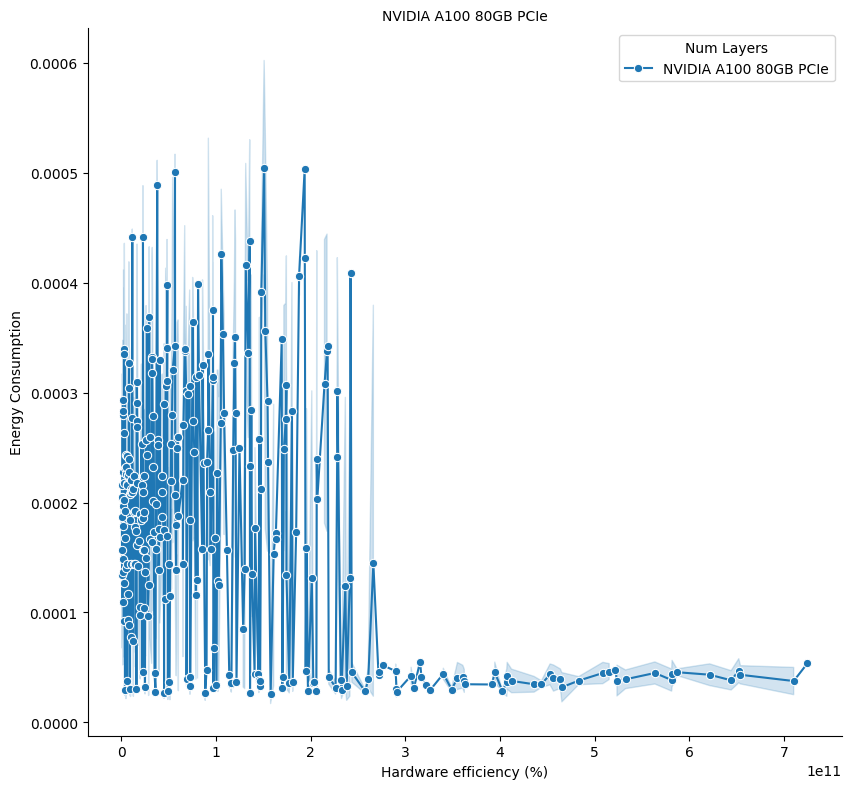

In [41]:
a100 = exclude_outliers_by_trend(
    a100,
    group_col='source',
    value_col='energy_consumed_kWh',
    num_std=10
)
g = sns.FacetGrid(a100, col="source", col_wrap=3, height=8, sharex=False, sharey=False)

# Map the lineplot to each facet
g.map(sns.lineplot, "FLOPs", "energy_consumed_kWh", "source",hue="source", marker="o")

# Add titles and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Hardware efficiency (%)", "Energy Consumption")
g.tight_layout()
for ax in g.axes.flat:
    ax.legend(title="Num Layers", loc="best")  # Customize legend position
#plt.savefig("images/HEF_energy.eps")

plt.show()

## 2) HEF for LSTM AND GRU

## LSTM Datasets import

In [4]:
import pandas as pd 
import pickle
import importlib
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import seaborn as sns
from collections import Counter 


dataForLstmHEF=pd.read_csv('dataForLstmHEF.csv', skiprows=None,usecols=None) # transformer_11122024_16H_metrics transformer_11122024_15H_metricsCentaure transformer_16122024_22H_metricsCenature
dataForLstmHEF.head()

,Unnamed: 0,source,batch_size,input_size,hidden_size,component,gpu_util,mem_used_MB,elapsed_time_sec,FLOPs,energy_consumed_kWh,total_gpu_energy_kWh,total_cpu_energy_kWh,total_ram_energy_kWh,seq_len,peak,flops_per_second,HEF
0,0,NVIDIA A100 80GB PCIe,64,64,64,Activations,0,1111,0.006912,16384,0.000113,0.000066,0.000033,0.000015,4,1.560000e+14,2.370370e+06,0.000002
1,1,NVIDIA A100 80GB PCIe,64,64,64,Cell Update,0,1111,0.005182,8192,0.000118,0.000068,0.000034,0.000015,4,1.560000e+14,1.580715e+06,0.000001
2,2,NVIDIA A100 80GB PCIe,64,64,64,Hidden Update,0,1111,0.000206,8192,0.000123,0.000072,0.000036,0.000016,4,1.560000e+14,3.980099e+07,0.000026
3,3,NVIDIA A100 80GB PCIe,64,64,64,compute_gates,0,1111,0.000336,2097152,0.000108,0.000062,0.000031,0.000014,4,1.560000e+14,6.243903e+09,0.004003
4,4,NVIDIA A100 80GB PCIe,64,64,64,hidden_gates,0,1111,0.000226,2097152,0.000102,0.000059,0.000030,0.000013,4,1.560000e+14,9.266969e+09,0.005940


In [5]:
Counter(dataForLstmHEF['component'])

Counter({'Activations': 2280,
         'Cell Update': 2280,
         'Hidden Update': 2280,
         'compute_gates': 2280,
         'hidden_gates': 2280})

In [6]:
pd.crosstab(dataForLstmHEF['source'],dataForLstmHEF['hidden_size'])

hidden_size,64,128,192,256,320,384,448,512,576,640,...,5760,6400,9600,12800,16000,19200,22400,25600,28800,32000
source,,,,,,,,,,,,,,,,,,,,,
NVIDIA A100 80GB PCIe,400,400,400,400,400,400,400,400,400,450,...,50,50,50,50,50,50,50,50,50,50
NVIDIA GeForce RTX 2080 Ti,200,200,200,200,200,200,200,200,200,650,...,450,450,0,0,0,0,0,0,0,0


In [7]:
pd.crosstab(dataForLstmHEF['source'],dataForLstmHEF['input_size'])

input_size,64,128,192,256,320,384,448,512,576,640
source,,,,,,,,,,
NVIDIA A100 80GB PCIe,400,400,400,400,400,400,400,400,400,1300
NVIDIA GeForce RTX 2080 Ti,650,650,650,650,650,650,650,650,650,650


In [8]:
pd.crosstab(dataForLstmHEF['source'],dataForLstmHEF['component'])

component,Activations,Cell Update,Hidden Update,compute_gates,hidden_gates
source,,,,,
NVIDIA A100 80GB PCIe,980,980,980,980,980
NVIDIA GeForce RTX 2080 Ti,1300,1300,1300,1300,1300


## LSTM HEF Modeling

Source=NVIDIA A100 80GB PCIe, coef Activations, :[9.64757989e-02 1.75442841e+04 9.40970267e-01]
Source=NVIDIA A100 80GB PCIe, coef Cell Update, :[5.53963177e-02 1.28238784e+04 8.76974773e-01]
Source=NVIDIA A100 80GB PCIe, coef Hidden Update, :[9.76856105e-02 1.02866994e+04 8.91797967e-01]
Source=NVIDIA A100 80GB PCIe, coef compute_gates, :[41.02787983 21.57095764  0.86167851]
Source=NVIDIA A100 80GB PCIe, coef hidden_gates, :[80.03886545 10.08345805  0.79205334]


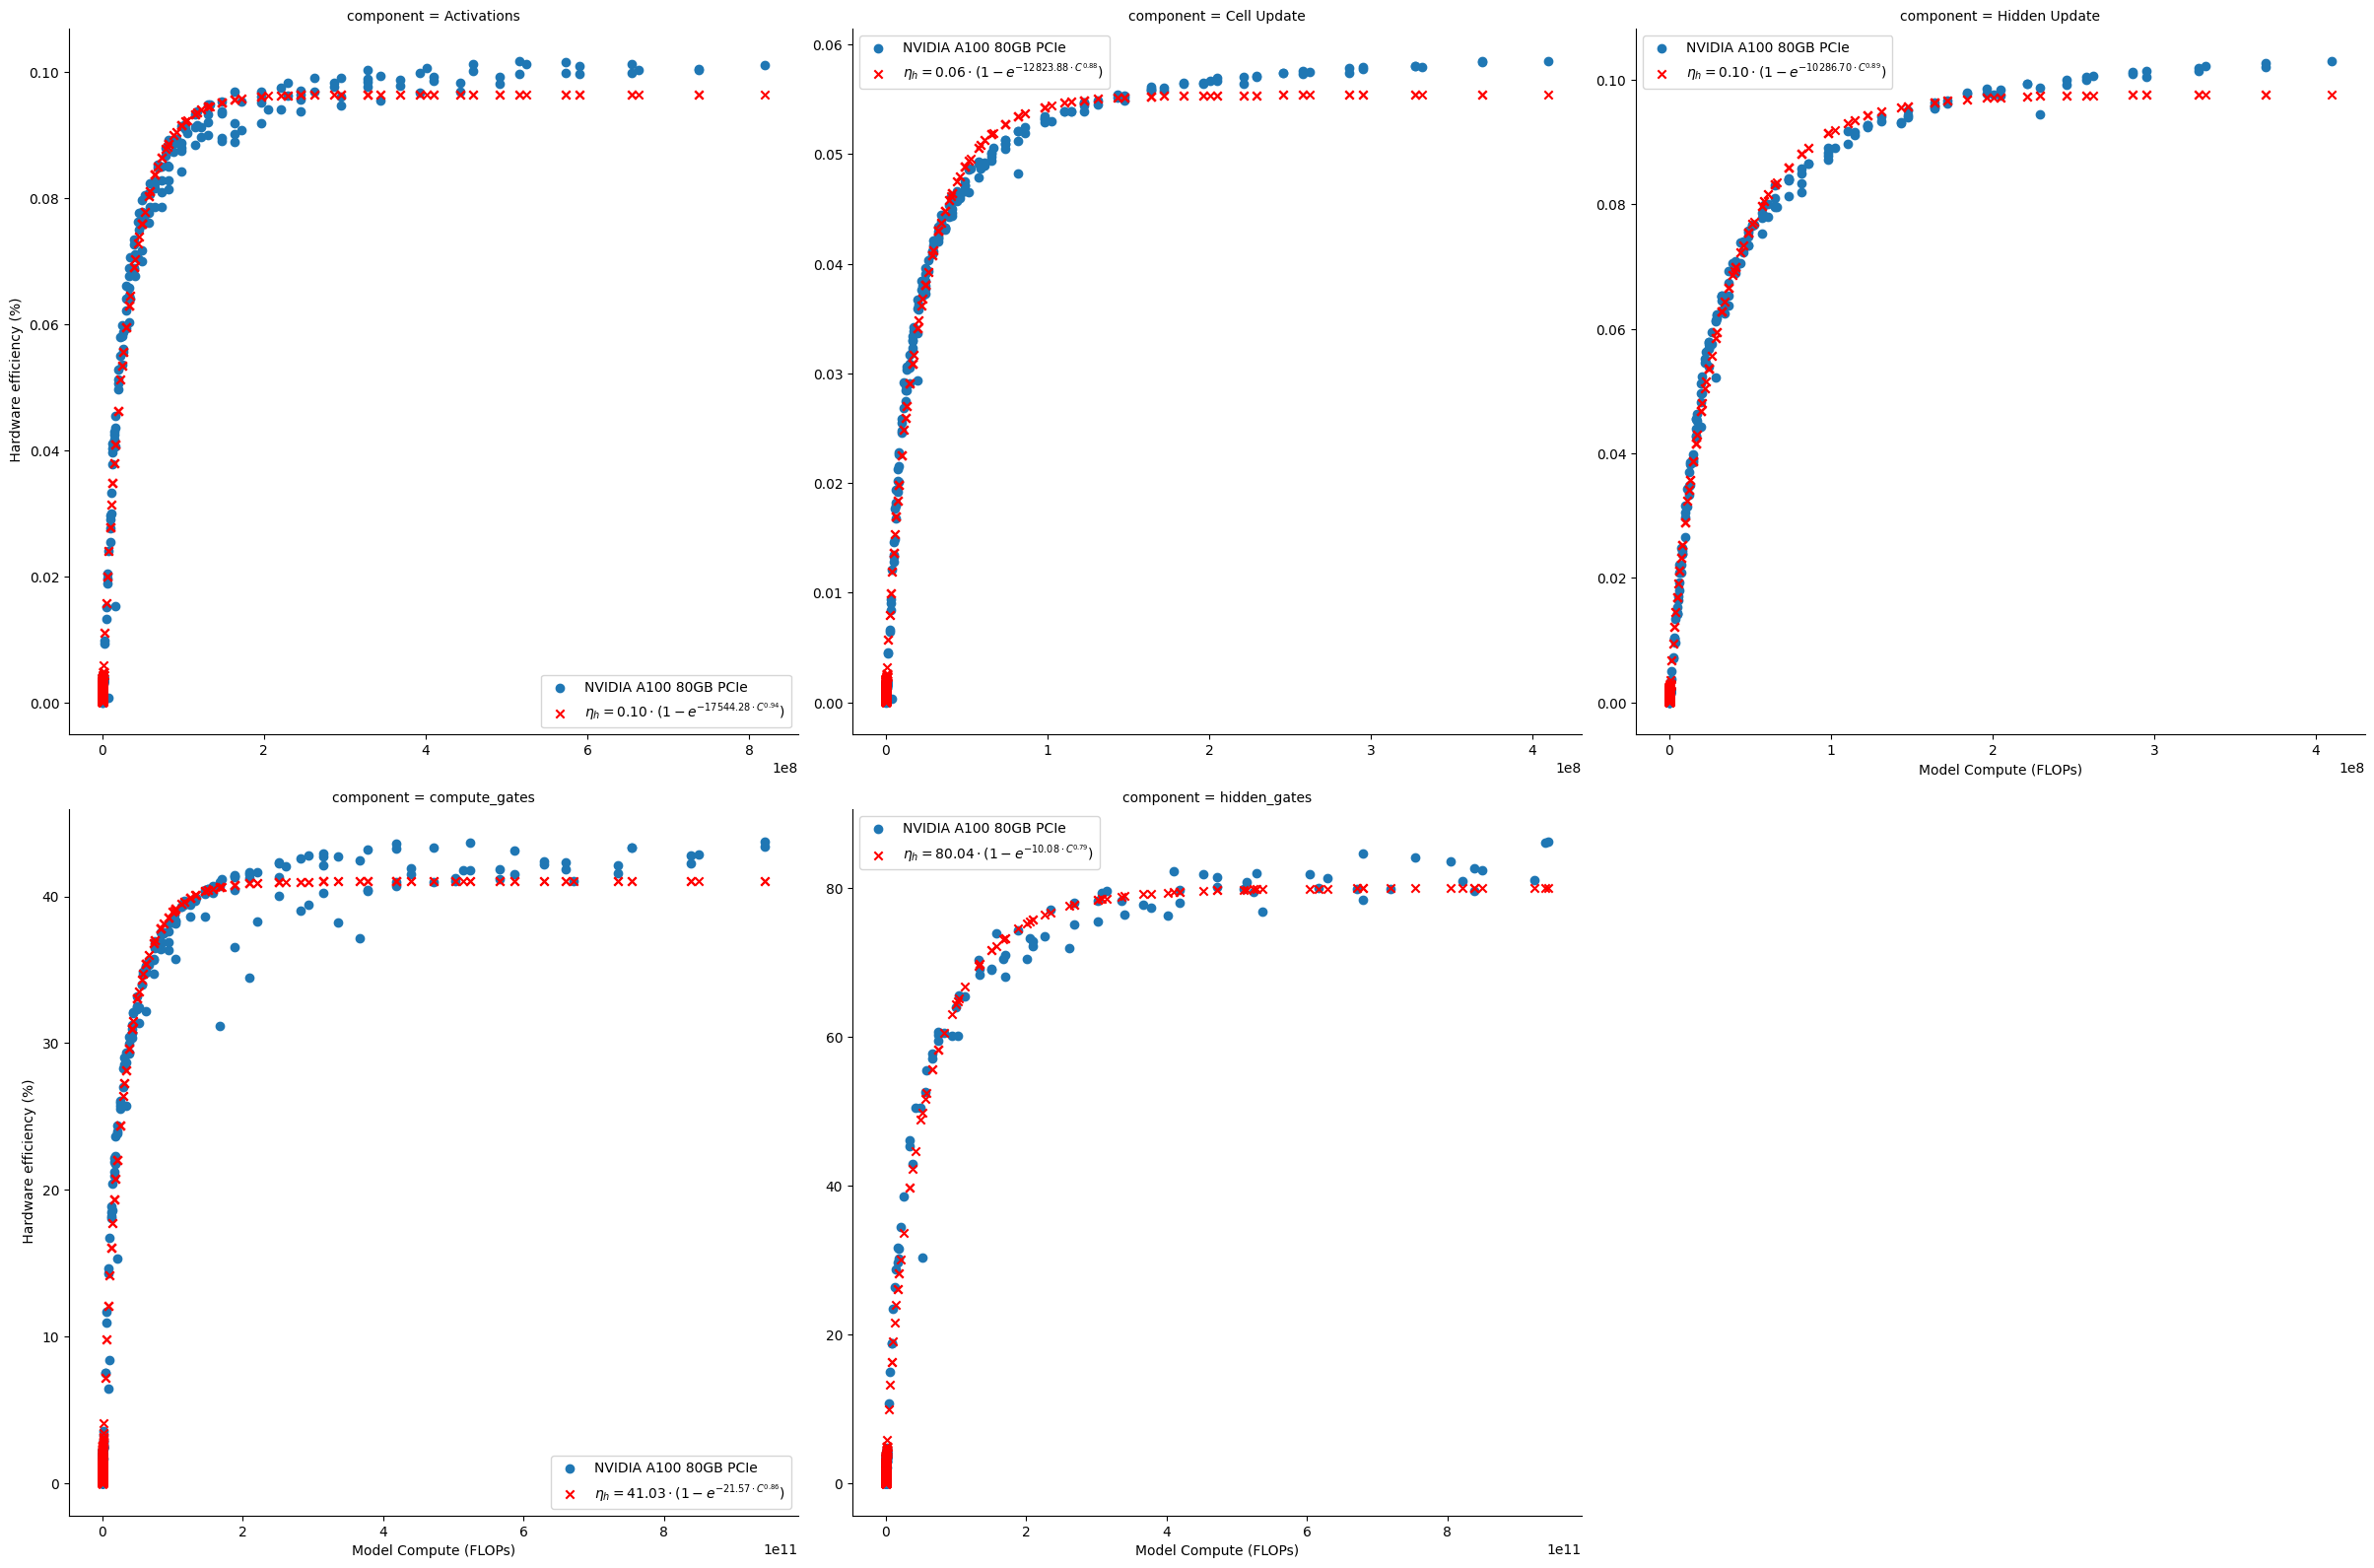

In [10]:
## Centaure très sensible au input_size
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
a100=dataForLstmHEF[dataForLstmHEF['source']=='NVIDIA A100 80GB PCIe'].copy()

a100["FLOPs"] /= 1e12
a100=a100[a100["FLOPs"]<1].copy()

g = sns.FacetGrid(a100, col="component",  hue="source",col_wrap=3, height=8, sharex=False, sharey=False)

g.map_dataframe(plot_exponential_decay_fit, x_col="FLOPs", y_col="HEF", data=a100)
for ax in g.axes.flat:
    ax.legend(loc="best")  # Customize legend position
g.set_axis_labels("Model Compute (FLOPs)", " Hardware efficiency (%)")
#plt.savefig("HEF_estimate_RNNs_.png")

plt.show()

# 2) Enegy models For LSTM AND GRU
Model by source of data: Grid5000 and A100

## 2.1) Using A100 data: the same data used to model HEF of components

In [16]:
df.columns

Index(['Unnamed: 0', 'source', 'batch_size', 'input_size', 'hidden_size',
       'component', 'FLOPs', 'energy_consumed_kWh', 'total_gpu_energy_kWh',
       'total_cpu_energy_kWh', 'total_ram_energy_kWh', 'seq_len', 'peak',
       'num_layers', 'FLOPs_Activations', 'FLOPs_Cell_Update', 'FLOPs_Gates',
       'FLOPs_Hidden_Update', 'hidden_gates', 'HEF_Activations',
       'duration_Activations', 'HEF_Cell_Update', 'duration_Cell_Update',
       'HEF_Hidden_Update', 'duration_Hidden_Update', 'HEF_hidden_gates',
       'duration_hidden_gates', 'HEF_Gates', 'duration_Gates'],
      dtype='object')

=== ALL POINTS ===
MAE (test): 159.0583
R² train:       0.9521
R² test:        0.9599

=== INLIERS (≤10% rel. err) ===
MAE (test): 151.8809
R² train:       0.9566
R² test:        0.9636
OLS params: duration_Activations=-75874.6467, duration_Cell_Update=44303.0453, duration_Gates=167.4528, duration_Hidden_Update=29867.7512


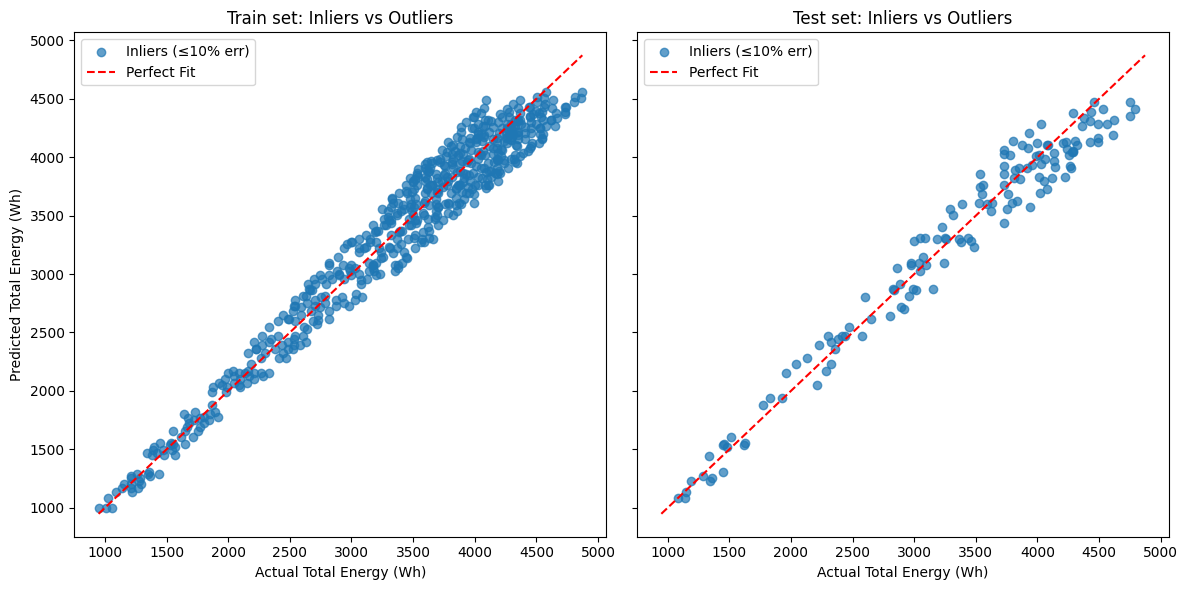

In [20]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import statsmodels.api as sm

df=pd.read_csv('SubsetDataForLSTM_energyModel.csv')
df['energy_consumed_kWh']=df['energy_consumed_kWh'].apply(lambda a: a* 3.6e6) ### Conver in Joules

features=['duration_Activations','duration_Cell_Update','duration_Gates','duration_Hidden_Update']


# 1) split
X_train0, X_test0, y_train, y_test = train_test_split(
    df,
    df['energy_consumed_kWh'],
    test_size=0.2,
    random_state=42
)

X_train, X_test=X_train0[features].copy(), X_test0[features].copy()
# 2) fit

model = LinearRegression().fit(X_train, y_train)

# 3) predict
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 4) compute relative errors
rel_err_train = np.abs(y_pred_train - y_train) / y_train
rel_err_test  = np.abs(y_pred_test  - y_test ) / y_test

# 5) pick your threshold (e.g. 10%)
thresh =0.1
train_mask = (rel_err_train <= thresh)
test_mask  = (rel_err_test  <= thresh)

# 6) re-compute metrics on inliers only
mae_in   = mean_absolute_error(y_test[test_mask],  y_pred_test[test_mask])
r2_train_in = r2_score(y_train[train_mask], y_pred_train[train_mask])
r2_test_in  = r2_score(y_test[test_mask],  y_pred_test[test_mask])

print("=== ALL POINTS ===")
print(f"MAE (test): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"R² train:       {r2_score(y_train, y_pred_train):.4f}")
print(f"R² test:        {r2_score(y_test,  y_pred_test):.4f}")

print("\n=== INLIERS (≤10% rel. err) ===")
print(f"MAE (test): {mae_in:.4f}")
print(f"R² train:       {r2_train_in:.4f}")
print(f"R² test:        {r2_test_in:.4f}")
print("OLS params:", ", ".join(f"{features[name]}={val:.4f}"
                                   for name, val in enumerate(model.coef_)))

# --- 7) Plotting: Side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# === Training Set Plot ===
axes[0].scatter(y_train[train_mask], y_pred_train[train_mask],
                c='C0', label='Inliers (≤10% err)', alpha=0.7)
mn, mx = min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())
axes[0].plot([mn, mx], [mn, mx], 'r--', label='Perfect Fit')
axes[0].set_xlabel("Actual Total Energy (Wh)")
axes[0].set_ylabel("Predicted Total Energy (Wh)")
axes[0].set_title("Train set: Inliers vs Outliers")
axes[0].legend()

# === Test Set Plot ===
axes[1].scatter(y_test[test_mask], y_pred_test[test_mask],
                c='C0', label='Inliers (≤10% err)', alpha=0.7)

axes[1].plot([mn, mx], [mn, mx], 'r--', label='Perfect Fit')
axes[1].set_xlabel("Actual Total Energy (Wh)")
axes[1].set_title("Test set: Inliers vs Outliers")
axes[1].legend()

plt.tight_layout()
plt.show()


## Finale energy model: This is the model used in the camera ready version of the ECAI Ppaer

In [21]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

X_centered = X_train[train_mask] - X_train[train_mask].mean()

X = sm.add_constant(X_centered)

model_statsmodels = sm.OLS(y_train[train_mask], X)

results = model_statsmodels.fit()

# 3. Get the confidence intervals for the parameters
confidence_intervals = results.conf_int(alpha=0.05) # 95% confidence interval

# Print the results
print("\nStatsmodels results summary:")
print(results.summary())

print("\nConfidence Intervals for Parameters:")
print(confidence_intervals)



Statsmodels results summary:
                             OLS Regression Results                            
Dep. Variable:     energy_consumed_kWh   R-squared:                       0.957
Model:                             OLS   Adj. R-squared:                  0.957
Method:                  Least Squares   F-statistic:                     3140.
Date:                 Thu, 24 Jul 2025   Prob (F-statistic):               0.00
Time:                         11:01:00   Log-Likelihood:                -3783.4
No. Observations:                  568   AIC:                             7577.
Df Residuals:                      563   BIC:                             7599.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

# 3.0) On GPT and bert from Centaure

In [22]:
import pandas as pd 
import pickle
import importlib
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import seaborn as sns
from collections import Counter 

data_transf=pd.read_csv('RawDataForTransformer_energyModel.csv')
data_transf.head()

,Unnamed: 0,duration,energy_joules,num_repeats,total_gpu_energy_kWh,total_cpu_energy_kWh,total_ram_energy_kWh,energy_wh_std_codecarbon,power_watt_std,time_sec_std,...,duration_QKV Projections,FLOPs_Attention Scores,HEF_Attention Scores,duration_Attention Scores,FLOPs_Attention Output,HEF_Attention Output,duration_Attention Output,FLOPs_Final Projection,HEF_Final Projection,duration_Final Projection
0,0,0.011418,0.992239,1,0.000000,7.235731e-07,2.661434e-07,0.0,0.0,0.0,...,0.000004,0.000537,1.878165,0.000004,0.000537,1.878165,0.000004,0.000268,1.119850,0.000003
1,1,0.012446,1.676083,1,0.000012,6.387458e-06,3.297791e-06,0.0,0.0,0.0,...,0.000005,0.002147,5.208760,0.000005,0.002147,5.208760,0.000005,0.000537,1.878165,0.000004
2,2,0.017370,4.110169,1,0.000033,1.176613e-05,6.102819e-06,0.0,0.0,0.0,...,0.000005,0.004832,9.292015,0.000007,0.004832,9.292015,0.000007,0.000805,2.537377,0.000004
3,3,0.023120,3.397739,1,0.000048,1.780529e-05,9.354081e-06,0.0,0.0,0.0,...,0.000006,0.008590,13.799794,0.000008,0.008590,13.799794,0.000008,0.001074,3.137870,0.000004
4,4,0.029440,3.695914,1,0.000074,2.461997e-05,1.301218e-05,0.0,0.0,0.0,...,0.000006,0.013422,18.507786,0.000009,0.013422,18.507786,0.000009,0.001342,3.697162,0.000005


In [28]:
data_transf.columns

Index(['operation', 'duration', 'power_watt_nvml', 'energy_joules_nvml',
       'num_repeats', 'energy_wh_codecarbon', 'total_gpu_energy_kWh',
       'total_cpu_energy_kWh', 'total_ram_energy_kWh',
       'energy_wh_std_codecarbon', 'power_watt_std', 'time_sec_std', 'params',
       'flops', 'raw_flops', 'seq_length', 'batch_size', 'num_layers',
       'd_model', 'num_attention_heads', 'model', 'source', 'peak',
       'component', 'total_energy_kWh', 'flops_counts', 'HEF',
       'FLOPs_QKV Projections', 'HEF_QKV Projections',
       'duration_QKV Projections', 'FLOPs_Attention Scores',
       'HEF_Attention Scores', 'duration_Attention Scores',
       'FLOPs_Attention Output', 'HEF_Attention Output',
       'duration_Attention Output', 'FLOPs_Final Projection',
       'HEF_Final Projection', 'duration_Final Projection'],
      dtype='object')

In [23]:
# 'seq_length', 'batch_size', 'num_layers', 'd_model', 'num_attention_heads', 'model'
Counter(data_transf['seq_length'])

Counter({256: 25571, 512: 21461, 768: 18847, 1024: 16645, 1280: 15327})

In [6]:
Counter(data_transf['batch_size'])

Counter({64: 29158,
         32: 24755,
         128: 16340,
         96: 11538,
         192: 6909,
         160: 3789,
         256: 3608,
         320: 1457,
         224: 153,
         288: 144})

In [9]:
Counter(data_transf['num_attention_heads'])

Counter({8: 29945, 2: 29630, 4: 29604, 12: 8672})

In [10]:
Counter(data_transf['model'])

Counter({'gpt': 64705, 'bert': 33146})

In [24]:
pd.crosstab(data_transf['model'],data_transf['num_layers'])

num_layers,2,4,6,12
model,,,,
bert,10200,9170,7918,5858
gpt,22136,17692,14690,10187


## 3.2) Transformers energy model for ECAI paper

# Simplified and Hugging face versions:  GPT Vs Bert
Here I mixed the data frommy simplified versions and the results from Hugging face models. I also used the data from the two GPUs

In [211]:
Counter(data_transf['model'])

Counter({'gpt': 64705, 'bert': 33146})

In [248]:
df.columns
features=['duration_QKV Projections','duration_Attention Scores','duration_Attention Output','duration_Final Projection'] 


Index(['operation', 'duration', 'power_watt_nvml', 'energy_joules_nvml',
       'num_repeats', 'energy_wh_codecarbon', 'total_gpu_energy_kWh',
       'total_cpu_energy_kWh', 'total_ram_energy_kWh',
       'energy_wh_std_codecarbon', 'power_watt_std', 'time_sec_std', 'params',
       'flops', 'raw_flops', 'seq_length', 'batch_size', 'num_layers',
       'd_model', 'num_attention_heads', 'model', 'source', 'peak',
       'component', 'total_energy_kWh', 'flops_counts', 'HEF',
       'FLOPs_QKV Projections', 'HEF_QKV Projections',
       'duration_QKV Projections', 'FLOPs_Attention Scores',
       'HEF_Attention Scores', 'duration_Attention Scores',
       'FLOPs_Attention Output', 'HEF_Attention Output',
       'duration_Attention Output', 'FLOPs_Final Projection',
       'HEF_Final Projection', 'duration_Final Projection', 'dur tottal'],
      dtype='object')

=== ALL POINTS ===
MAE (test): 6.6594
R² train:    0.9696
R² test:     0.9668

=== INLIERS (≤25% rel. err) ===
MAE (test): 6.6408
R² train:    0.9704
R² test:     0.9668
OLS params: duration_QKV Projections=0.0000, duration_Attention Scores=0.0000, duration_Final Projection=0.0000
Intercept: 10.31081345721313


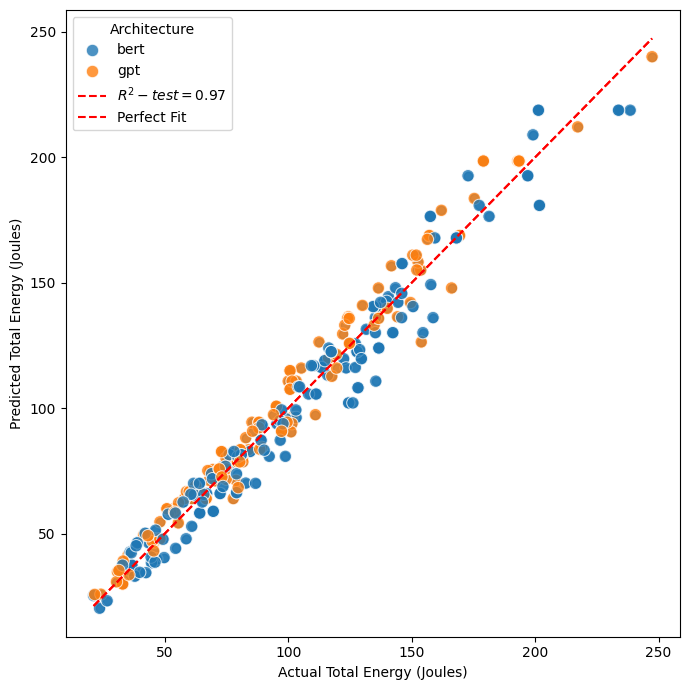

In [26]:
## Utiliser flops et parametres en plus de HEF permet de supprimer l'effet 
## du nombre de layers
## Sinon il faut fixer le layer pour avoir des bon results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
def exponential_decay(x, L, k):
    return L * (1 - np.exp(-k * x))
df=pd.read_csv('SubsetDataForTransformer_energyModel.csv')
features=['duration_QKV Projections','duration_Attention Scores','duration_Final Projection'] 

df['dur tottal']=df[['duration_QKV Projections','duration_Attention Scores','duration_Final Projection'] ].sum(axis=1)



pred_col='energy_joules' #'total_energy_kWh' energy_joules_nvml

df[features] = df[features].apply(lambda a: a * 1e6) ## convert the durations into micro seconds
#df['energy_joules_nvml'] = df['energy_joules_nvml'].apply(lambda a: a / 3.6e3) ## convert the durations into micro seconds

# Split the dataset into training and testing sets
import seaborn as sns
# 1) split as before
X_train0, X_test0, y_train, y_test = train_test_split(
    df, df[pred_col],
    test_size=0.2,
    stratify=df[['model', 'num_layers']],
    random_state=42
)
X_train, X_test=X_train0[features].copy(), X_test0[features].copy()
# 2) fit
model = LinearRegression().fit(X_train, y_train)

# 3) predict
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 4) compute relative errors
rel_err_train = np.abs(y_pred_train - y_train) / y_train
rel_err_test  = np.abs(y_pred_test  - y_test ) / y_test

# 5) thresholds
thresh = 0.2
train_mask = (rel_err_train <= thresh)
test_mask  = (rel_err_test  <= thresh)

# 6) metrics
print("=== ALL POINTS ===")
print(f"MAE (test): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"R² train:    {r2_score(y_train, y_pred_train):.4f}")
print(f"R² test:     {r2_score(y_test,  y_pred_test):.4f}")

print("\n=== INLIERS (≤25% rel. err) ===")
print(f"MAE (test): {mean_absolute_error(y_test[test_mask], y_pred_test[test_mask]):.4f}")
print(f"R² train:    {r2_score(y_train[train_mask], y_pred_train[train_mask]):.4f}")
print(f"R² test:     {r2_score(y_test[test_mask],  y_pred_test[test_mask]):.4f}")
print("OLS params:", ", ".join(f"{features[name]}={val:.4f}"
                                   for name, val in enumerate(model.coef_)))
print("Intercept:", model.intercept_)

r2_test = r2_score(y_test[test_mask],  y_pred_test[test_mask])
# 7) build a test‐DataFrame that includes num_layers
df_test = X_test.copy()
df_test['actual']       = y_test
df_test['predicted']    = y_pred_test
# retrieve num_layers by reindexing original df
df_test['model']   = df.loc[y_test.index, 'model']

# 8) plot with seaborn
plt.figure(figsize=(7,7))

plt.scatter(
    y_test[test_mask],
    y_pred_test[test_mask],
    c='C0', alpha=0.7
)
# perfect‐fit line
mn, mx = df_test[test_mask]['actual'].min(), df_test[test_mask]['actual'].max()


sns.scatterplot(
    data=df_test[test_mask],
    x="actual", y="predicted",
    hue="model",
    palette="tab10",
    alpha=0.8,
    edgecolor="w",
    s=80
)
plt.plot([mn, mx], [mn, mx], 'r--', label=f"$R^2 - test=${r2_test:.2f}")

#plt.scatter(np.exp(y_train), np.exp(y_pred_train), color="blue", alpha=0.7, label=f"$R^2=${r2_train:.2f}")
plt.plot([mn, mx], [mn, mx], 'r--', label='Perfect Fit')

plt.xlabel("Actual Total Energy (Joules)")
plt.ylabel("Predicted Total Energy (Joules)")
#plt.title("Test Set Predictions Colored by num_layers")
plt.legend(title="Architecture")
plt.tight_layout()
#plt.savefig("bert-gpt-predictions2.png")
plt.savefig("bert-gpt-predictions2.png")

plt.show()



In [27]:
import statsmodels.api as sm
#X = sm.add_constant(X_train[train_mask])
X_centered = X_train[train_mask] - X_train[train_mask].mean()

X = sm.add_constant(X_centered)
model_statsmodels = sm.OLS(y_train[train_mask], X)
results = model_statsmodels.fit()

# 3. Get the confidence intervals for the parameters
confidence_intervals = results.conf_int(alpha=0.05) # 95% confidence interval

# Print the results
print("\nStatsmodels results summary:")
print(results.summary())

print("\nConfidence Intervals for Parameters:")
print(confidence_intervals)


Statsmodels results summary:
                            OLS Regression Results                            
Dep. Variable:          energy_joules   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 1.357e+04
Date:                Thu, 24 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:07:13   Log-Likelihood:                -4357.9
No. Observations:                1246   AIC:                             8724.
Df Residuals:                    1242   BIC:                             8744.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------